# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [46]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_PG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_PG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_Folder_PG(EC)'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Tugba Sanver-PG-test_functions.ipynb', 'Code', 'CW_Dataset', 'Video', 'Models']


### Load packages 

In the next cell you should load all the packages required to test your functions.

In [47]:
!pip install opencv-python==4.5.5.64

In [48]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import dump, load
import cv2
from skimage import img_as_ubyte, io, color
from skimage.feature import hog
import random
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches
from numpy.random import seed
from numpy.random import randint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from joblib import dump, load

### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `EmotionRecognition` and `EmotionRecognitionVideo` to avoid having to reload them each time.

In [49]:
#reference: https://joblib.readthedocs.io/en/latest/generated/joblib.load.html

#sift+svm model loading:
with open(os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'sift+svm.joblib'), 'rb') as f:
    sift_svm=load(f)

#hog+svm model loading:
with open(os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'hog+svm.joblib'), 'rb') as f:
    hog_svm=load(f)

#cnn model loading:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=7, stride=1, padding=5),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=5, stride=2),
            nn.Conv2d(4, 4, kernel_size=7, stride=1, padding=5),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=5, stride=2),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(4 *25 * 25, 8)
        )
   
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

cnn=Net()

cnn.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','cnn_net.pth')))
cnn.eval()

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(7, 7), stride=(1, 1), padding=(5, 5))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(7, 7), stride=(1, 1), padding=(5, 5))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=2500, out_features=8, bias=True)
  )
)

Emotion names for labels to encoding:

In [50]:
emotion_dict={
1: 'Surprise',
2: 'Fear',
3: 'Disgust',
4: 'Happiness',
5: 'Sadness',
6: 'Anger',
7: 'Neutral'
}


# Test EmotionRecognition

This section should allow a quick test of the `EmotionRecognition` function. First, add cells with the code needed to load the necessary subroutines to make `EmotionRecognition` work.

(I tried to write different, simpler functions for each model but since I had a limited time I could not manage the whole calling errors. Sorry for the bad coding!)

In [51]:
#reference for this cell code: lab 07, lab 08 solution and https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/


def EmotionRecognition(path_to_testset, model_type): 
  path=path_to_testset
  images=[]
  file_names = [file for file in sorted(os.listdir(os.path.join(path))) if file.endswith('.jpg')]
  for file in file_names:
      images.append(io.imread(os.path.join(path, file)))

  test_labels = pd.read_csv(os.path.join(path_to_testset, 'list_label_test.txt'), header=None, sep=',')
  test_labels[['image_title', 'label']] = test_labels[0].str.split(' ', 1, expand=True)
  y_testlabel=test_labels['label']
  image_title=test_labels['image_title']

####### SIFT+SVM MODEL #######
  if model_type==sift_svm:
    #SIFT creation
    sift = cv2.SIFT_create()
    des_list = []
    y_test = []

    for i in range(len(images)):
      img = img_as_ubyte(color.rgb2gray(images[i]))
      kp, des = sift.detectAndCompute(img, None)

      if des is not None:
          des_list.append(des)
          y_test.append(y_testlabel[i])

    des_array = np.vstack(des_list)
    k = len(np.unique(y_test)) * 10
    batch_size = des_array.shape[0] // 4
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)

    # Convert descriptors into histograms of codewords for each image
    hist_list = []
    idx_list = []

    for des in des_list:
      hist = np.zeros(k)
      idx = kmeans.predict(des)
      idx_list.append(idx)
      for j in idx:
          hist[j] = hist[j] + (1 / len(des))
      hist_list.append(hist)
    X_test = np.vstack(hist_list)
    y_pred = model_type.predict(X_test)

####### HOG+SVM MODEL #######
  if model_type==hog_svm:
    #HOG creation
    X_test=[]
    HOG_image_list=[]
    y_test=y_testlabel
    for i in range(len(images)):
    # Identify keypoints and extract descriptors with HOG
      imgs = img_as_ubyte(images[i])
      HOG_des, HOG_image = hog(imgs, orientations=8, pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1), visualize=True, multichannel=True)
      X_test.append(HOG_des)
      HOG_image_list.append(HOG_image)
    y_pred = model_type.predict(X_test)

####### CNN MODEL #######
  if model_type==cnn:
    X_test=np.array(images)
    train_img=[]
    for i in range(len(X_test)):
      img = X_test[i].astype('float32')
      train_img.append(img)

    X_test = np.array(train_img)
    X_test = X_test.reshape(3068, 3, 100, 100)
    X_test  = torch.from_numpy(X_test)
    with torch.no_grad():
      output = cnn(X_test)
      
    softmax = torch.exp(output)
    prob = list(softmax.numpy())
    y_pred = np.argmax(prob, axis=1)
    y_pred = y_pred.astype(int)
    y_test=np.array(y_testlabel)   


  #4 sample image ground truth for predictions
  fig, axes = plt.subplots(1, 4, figsize=(14, 7), sharex=True, sharey=True)
  ax = axes.ravel()

  for i in range(4):
      ax[i].imshow(images[i])
      a=int(y_test[i])
      b=int(y_pred[i])
      ax[i].set_title(f'Label: {emotion_dict[a]} \n Prediction: {emotion_dict[b]} \n Image title: {image_title[i]}')
      ax[i].set_axis_off()
  fig.tight_layout()
  plt.show()

  return y_test, y_pred

Then, make a call to the `EmotionRecognition` function to see what results it produces. You must also indicate the syntax needed to test your different models.

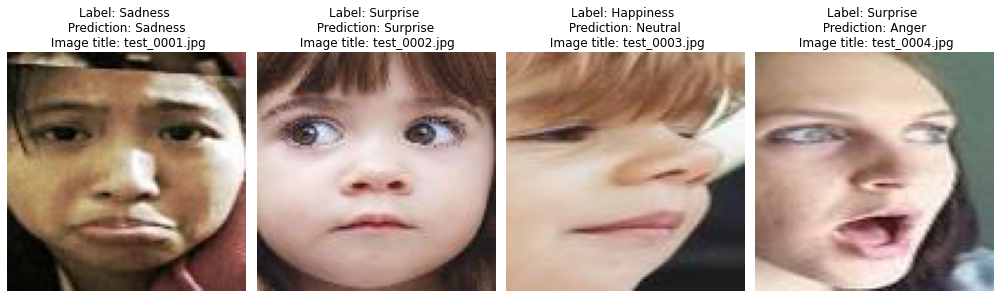

In [62]:
# where model_type can be one of
#   - sift_svm
#   - hog_svm
#   - cnn

path_to_testset = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/test')
y_test, y_pred = EmotionRecognition(path_to_testset, hog_svm)

Confusion matrix for relevant model:

In [63]:
#type transformation:
y_pred_list=[0]

for a in range(len(y_pred)):
  y_pred_list.append(int(y_pred[a]))

#type transformation:
y_test_list=[0]

for a in range(len(y_test)):
  y_test_list.append(int(y_test[a]))

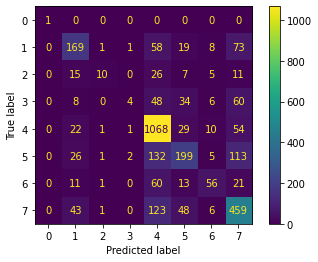

In [64]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test_list, y_pred_list) #code reference: lab 08
plt.show()

Classification report for relevant model:

In [65]:
print(f"""Classification report for classifier:\n
      {metrics.classification_report(y_test_list, y_pred_list)}""") #code reference: lab 08

Classification report for classifier:

                    precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.57      0.51      0.54       329
           2       0.67      0.14      0.22        74
           3       0.50      0.03      0.05       160
           4       0.70      0.90      0.79      1185
           5       0.57      0.42      0.48       478
           6       0.58      0.35      0.43       162
           7       0.58      0.68      0.62       680

    accuracy                           0.64      3069
   macro avg       0.65      0.50      0.52      3069
weighted avg       0.62      0.64      0.61      3069



# Test EmotionRecognitionVideo

This section should allow a quick test of the `EmotionRecognitionVideo` function. First, add cells with the code needed to load the necessary subroutines to make `EmotionRecognitionVideo` work.

In [56]:
def EmotionRecognitionVideo(path): #code reference: lab 05 solution
  #importing video
  cap = cv2.VideoCapture(os.path.join(GOOGLE_DRIVE_PATH,'Video', path))
  frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  video = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))
  
  fc = 0
  ret = True

  while fc < frameCount and ret:
      ret, video[fc] = cap.read()
      video[fc] = cv2.cvtColor(video[fc], cv2.COLOR_BGR2RGB)
      fc += 1

  cap.release()

  # I created random number generator to generate random frames from the video to test the algorithm
  #reference: https://machinelearningmastery.com/how-to-generate-random-numbers-in-python/#:~:text=An%20array%20of%20random%20integers,the%20size%20of%20the%20array.

  values = randint(1, frameCount, 4)

  img1 = video[values[0], :, :, :]
  img2 = video[values[1], :, :, :]
  img3 = video[values[2], :, :, :]
  img4 = video[values[3], :, :, :]
  img_a=[img1, img2, img3, img4]

  #Hog extractions to prepare image to model prediction
  X_test_video=[]
  HOG_imagelist_video=[]
  faces_array=[]

  for i in range(len(img_a)):
    img_rs=cv2.resize(img_a[i], (100, 100), interpolation = cv2.INTER_AREA) #resizing the image for hog function
    imgs_v = img_as_ubyte(img_rs)
    HOG_des_video, HOG_image_video = hog(imgs_v, orientations=8, pixels_per_cell=(16,16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    X_test_video.append(HOG_des_video)
    HOG_imagelist_video.append(HOG_image_video)
    
    #face detection function:
    img_gray = color.rgb2gray(img_a[i])
    img_gray = img_as_ubyte(img_gray)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') #reference: lab 06 solution
    faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
    faces_array.append(faces)

  #model prediction
  y_pred_video = hog_svm.predict(X_test_video)

  fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True, sharey=True)
  ax = axes.ravel()

  #displaying 4 random frames with face and emotion detection
  for i in range(4):
      ax[i].imshow(img_a[i])
      ax[i].set_axis_off()
      for face in faces_array[i]:
        rect=mpatches.Rectangle(xy=(face[0], face[1]), width=face[2], height=face[3],
                    fill=False, color='r', linewidth=2)
        ax[i].add_patch(
            mpatches.Rectangle(xy=(face[0], face[1]), width=face[2], height=face[3],
                              fill=False, color='r', linewidth=2))
        ax[i].add_patch(rect)
        rx, ry = rect.get_xy() #reference: https://www.tutorialspoint.com/how-to-add-a-text-into-a-rectangle-in-matplotlib
        cx = rx + 50
        cy = ry - 10
        a=int(y_pred_video[i])
        ax[i].annotate(emotion_dict[a], (cx, cy), color='red', fontsize=14, ha='center', va='center')
  fig.tight_layout()
  plt.show()


Then, make a call to the `EmotionRecognitionVideo` function to see what results it produces.

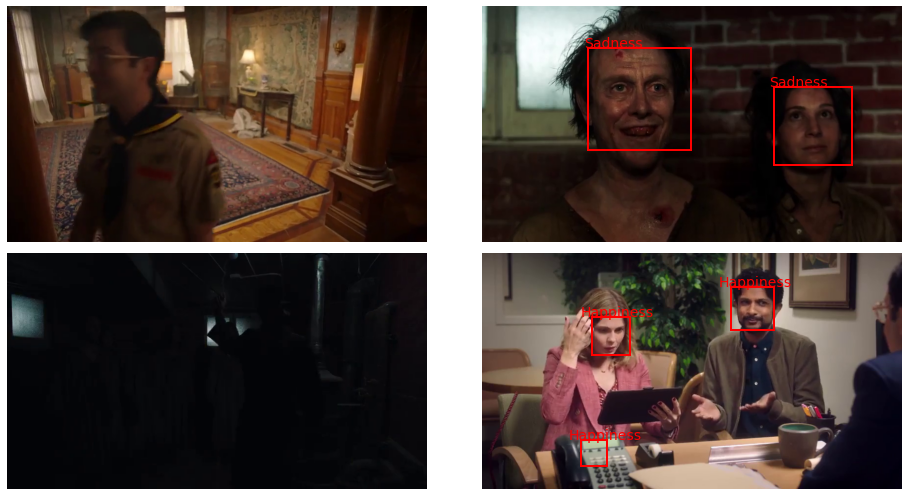

In [57]:
EmotionRecognitionVideo('videoplayback.avi')